Inspired by: https://www.kaggle.com/code/arunmohan003/sentiment-analysis-using-lstm-pytorch 

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import torch.nn as nn
import torch.nn.functional as F
from nltk.corpus import stopwords 
from collections import Counter
import string
import re
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

In [2]:
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


In [12]:
from datasets import load_dataset

dataset = load_dataset('ar_res_reviews')

Generating train split:   0%|          | 0/8364 [00:00<?, ? examples/s]

In [13]:
dir(dataset)

['__class__',
 '__class_getitem__',
 '__contains__',
 '__delattr__',
 '__delitem__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__enter__',
 '__eq__',
 '__exit__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__ior__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__or__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__reversed__',
 '__ror__',
 '__setattr__',
 '__setitem__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_check_values_features',
 '_check_values_type',
 'align_labels_with_mapping',
 'cache_files',
 'cast',
 'cast_column',
 'class_encode_column',
 'cleanup_cache_files',
 'clear',
 'column_names',
 'copy',
 'data',
 'filter',
 'flatten',
 'flatten_indices',
 'formatted_as',
 'from_csv',
 'from_json',
 'from_parquet',
 'from_text',
 'fromkeys',
 'get',
 'items',
 'keys',
 'load_from_disk',
 'map',
 'num_columns',
 'num_r

In [14]:
dataset.keys()

dict_keys(['train'])

In [15]:
len(dataset['train'])

8364

In [16]:
dataset['train'][0]

{'polarity': 0,
 'text': 'اولا: المنيو تغير الشورما اصبحت اعتياديه بأختفاء الصلصات والخيارات  \n ثانيا : في المره الاولي لطلبي وجدنا قطعه من قفاز الايدي في الدجاج واعتقدنا مبدأيا بأنه من جلد الدجاج  حتي تأكدنا ومنه قررنا ان لا نشتري منه لكن -للبطن احكام :-) \n ثالثا : طلبت بالمره الاخيره الطبق المفضل لي صحن الشورما (شورما بالتر ) فجاء الطلب من غير خبز او صلصه ولا مجال للعوده للمحل والشكوي  \n قرار اخير لا اطلب من اكسبرس مجددا',
 'restaurant_id': '296',
 'user_id': '423'}

In [17]:
df = pd.DataFrame(dataset['train'])
df.head()

,polarity,text,restaurant_id,user_id
0,0,اولا: المنيو تغير الشورما اصبحت اعتياديه بأختف...,296,423
1,0,من محلات الشاورما ذات الشعبيه لتميز الصلصات ال...,296,423
2,1,دجاج طازج يحضر امامك على الطلب لا يقوم باعدة ا...,5027,39580
3,1,فكما تعرف أستراليا بالكنغر والكوالا. فإنها تعر...,642,444
4,0,إسمحو لي أن أقيم مطعم هاشم بصفتي فلسطيني عشت ف...,434,2191


In [18]:
df['sentiment'] = df['polarity'].map(lambda polarity: "negative" if polarity == 0 else "positive")

### Splitting to train and test data

We will split data to train and test initially. Doing this on earlier stage allows to avoid data lekage.


In [94]:
X,y = df['text'].values,df['sentiment'].values
x_train,x_test,y_train,y_test = train_test_split(X,y,stratify=y)
print(f'shape of train data is {x_train.shape}')
print(f'shape of test data is {x_test.shape}')

shape of train data is (6273,)
shape of test data is (2091,)


### Analysing sentiment

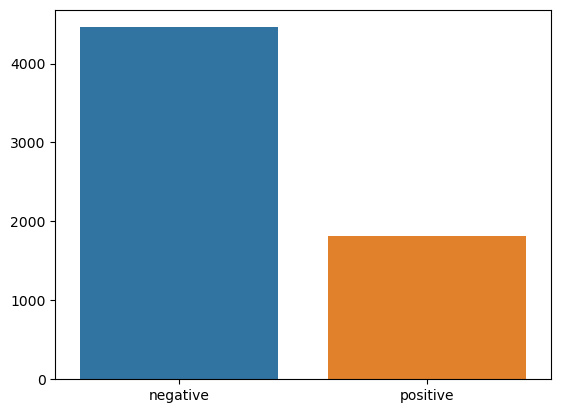

In [95]:
dd = pd.Series(y_train).value_counts()
sns.barplot(x=np.array(['negative','positive']),y=dd.values)
plt.show()

### Tockenization

In [96]:
import nltk
nltk.download('stopwords')

stopwords.words('arabic')[:10]

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\harri\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['إذ', 'إذا', 'إذما', 'إذن', 'أف', 'أقل', 'أكثر', 'ألا', 'إلا', 'التي']

In [97]:
def preprocess_string(s):
    # Remove all non-word characters (everything except numbers and letters)
    s = re.sub(r"[^\w\s]", '', s)
    # Replace all runs of whitespaces with no space
    s = re.sub(r"\s+", ' ', s)
    # replace digits with no space
    s = re.sub(r"\d", '', s)

    return s

In [98]:
"الدجاج واعتقدنا مبدأيا بأنه من جلد الدجاج    حتي تأكدنا ومنه قررنا ان لا نشتري منه لكن -للبطن احكام".split()

['الدجاج',
 'واعتقدنا',
 'مبدأيا',
 'بأنه',
 'من',
 'جلد',
 'الدجاج',
 'حتي',
 'تأكدنا',
 'ومنه',
 'قررنا',
 'ان',
 'لا',
 'نشتري',
 'منه',
 'لكن',
 '-للبطن',
 'احكام']

In [109]:
def tokenize(x_train,y_train,x_val,y_val):
    word_list = []

    stop_words = set(stopwords.words('arabic')) 
    for sent in x_train:
        for word in sent.split():
            word = preprocess_string(word)
            if word not in stop_words and word != '':
                word_list.append(word)
  
    corpus = Counter(word_list)
    # sorting on the basis of most common words
    corpus_ = sorted(corpus,key=corpus.get,reverse=True)[:1000]
    # creating a dict
    onehot_dict = {w:i+1 for i,w in enumerate(corpus_)}
    
    # tockenize
    final_list_train, final_list_test = [],[]
    for sent in x_train:
            final_list_train.append([onehot_dict[preprocess_string(word)] for word in sent.split() 
                                     if preprocess_string(word) in onehot_dict.keys()])
    for sent in x_val:
            final_list_test.append([onehot_dict[preprocess_string(word)] for word in sent.split() 
                                    if preprocess_string(word) in onehot_dict.keys()])
            
    encoded_train = [1 if label =='positive' else 0 for label in y_train]  
    encoded_test = [1 if label =='positive' else 0 for label in y_val] 
    
    #train_ids = np.array(final_list_train)
    #test_ids = np.array(final_list_test)
    train_y = np.array(encoded_train)
    
    test_y = np.array(encoded_test)
    
    return final_list_train, train_y, final_list_test, test_y,onehot_dict

In [100]:
x_train,y_train,x_test,y_test,vocab = tokenize(x_train,y_train,x_test,y_test)

[[201, 419], [949], [636, 379, 328, 575], [847], [176, 74, 847, 22, 17], [53, 478, 33, 24, 35, 478, 20, 3, 599, 334, 93, 600, 248, 26, 328, 26, 194, 10], [37, 10, 4, 576, 437, 362, 67, 70, 67, 14, 2, 201, 249, 780, 479, 230, 673, 95, 331, 674, 9, 89, 491, 89, 15], [577, 38, 13, 178, 141, 20, 20, 807, 53, 398, 903, 309, 754, 904, 451, 310, 117, 950, 807, 35, 114, 904, 451, 114, 728, 185, 688, 141, 262, 388, 25, 47, 925, 578, 40, 291, 206, 45, 466, 138, 152, 262, 480, 53], [3, 299, 20], [1, 223, 80, 637, 35, 179, 2, 61]] <class 'list'>
[1, 0, 1, 1, 1, 1, 1, 1, 1, 0]
[[116, 13, 178, 70, 21, 442, 32, 7, 2, 71, 60, 10, 700, 761], [71, 11, 320, 262, 585, 605, 645, 260, 31, 10, 886], [820], [63], [202, 387, 244], [263, 219, 109], [5, 291], [40, 13, 715, 11, 58, 21, 5], [66, 114, 53, 182, 119], [53, 126, 2, 84, 77, 14, 551, 478, 337, 815, 70, 906, 173, 173]]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 0]
{'المطعم': 1, 'جدا': 2, 'مطعم': 3, 'اللي': 4, 'عندهم': 5, 'ان': 6, 'لذيذ': 7, 'شي': 8, 'كانت': 9, 'المطاعم

In [101]:
print(f'Length of vocabulary is {len(vocab)}')

Length of vocabulary is 1000


### Analysing review length

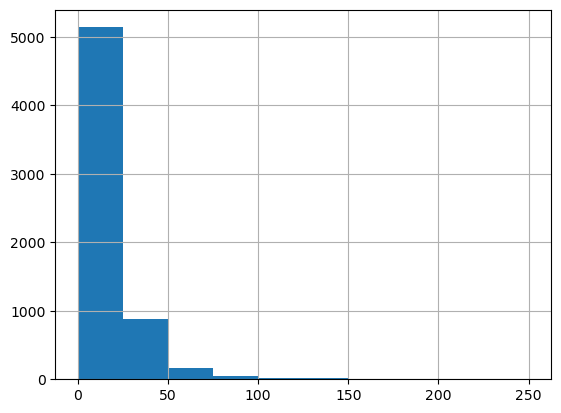

count    6273.000000
mean       15.484617
std        17.817844
min         0.000000
25%         5.000000
50%        10.000000
75%        19.000000
max       250.000000
dtype: float64

In [102]:
rev_len = [len(i) for i in x_train]
pd.Series(rev_len).hist()
plt.show()
pd.Series(rev_len).describe()

Observations : <br>a) Mean review length = around 18.<br> b) minimum length of reviews is 0.<br>c)There are quite a few reviews that are extremely long, we can manually investigate them to check whether we need to include or exclude them from our analysis.

In [103]:
len([s for s in x_train if len(s) == 0])

118

In [104]:
x_train_not_empty = []
y_train_not_empty = []
x_test_not_empty = []
y_test_not_empty = []

for i, x in enumerate(x_train):
    if len(x) > 0:
        x_train_not_empty.append(x)
        y_train_not_empty.append(y_train[i])

for i, x in enumerate(x_test):
    if len(x) > 0:
        x_test_not_empty.append(x)
        y_test_not_empty.append(y_test[i])

In [106]:
len(x_train_not_empty), len(x_test_not_empty)

(6155, 2051)

### Padding

Now we will pad each of the sequence to max length 

In [110]:
def padding_(sentences, seq_len):
    features = np.zeros((len(sentences), seq_len),dtype=int)
    for ii, review in enumerate(sentences):
        if len(review) != 0:
            features[ii, -len(review):] = np.array(review)[:seq_len]
    return features

In [111]:
#we have very less number of reviews with length > 500.
#So we will consideronly those below it.
x_train_pad = padding_(x_train_not_empty, 500)
x_test_pad = padding_(x_test_not_empty, 500)

In [112]:
x_train_pad.shape, x_test_pad.shape

((6155, 500), (2051, 500))

In [114]:
y_train = np.array(y_train_not_empty)
y_test = np.array(y_test_not_empty)

### Batching and loading as tensor

In [127]:
# create Tensor datasets
train_data = TensorDataset(torch.from_numpy(x_train_pad), torch.from_numpy(y_train))
valid_data = TensorDataset(torch.from_numpy(x_test_pad), torch.from_numpy(y_test))

# dataloaders
batch_size = 50

# make sure to SHUFFLE your data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last=True)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size, drop_last=True)

In [128]:
# obtain one batch of training data
dataiter = iter(train_loader)
sample_x, sample_y = next(dataiter)

print('Sample input size: ', sample_x.size()) # batch_size, seq_length
print('Sample input: \n', sample_x)
print('Sample input: \n', sample_y)

Sample input size:  torch.Size([50, 500])
Sample input: 
 tensor([[  0,   0,   0,  ...,  56,   2, 176],
        [  0,   0,   0,  ..., 816, 442, 228],
        [  0,   0,   0,  ..., 649, 457,   7],
        ...,
        [  0,   0,   0,  ...,   4, 420, 548],
        [  0,   0,   0,  ...,  66, 798, 112],
        [  0,   0,   0,  ..., 113, 147, 415]], dtype=torch.int32)
Sample input: 
 tensor([1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1,
        1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
        1, 1], dtype=torch.int32)


We need to add an embedding layer because there are less words in our vocabulary. It is massively inefficient to one-hot encode that many classes. So, instead of one-hot encoding, we can have an embedding layer and use that layer as a lookup table. You could train an embedding layer using Word2Vec, then load it here. But, it's fine to just make a new layer, using it for only dimensionality reduction, and let the network learn the weights.

### Model

In [129]:
class SentimentRNN(nn.Module):
    def __init__(self,no_layers,vocab_size,hidden_dim,embedding_dim,drop_prob=0.5):
        super(SentimentRNN,self).__init__()
 
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
 
        self.no_layers = no_layers
        self.vocab_size = vocab_size
    
        # embedding and LSTM layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        #lstm
        self.lstm = nn.LSTM(input_size=embedding_dim,hidden_size=self.hidden_dim,
                           num_layers=no_layers, batch_first=True)
        
        
        # dropout layer
        self.dropout = nn.Dropout(0.3)
    
        # linear and sigmoid layer
        self.fc = nn.Linear(self.hidden_dim, output_dim)
        self.sig = nn.Sigmoid()
        
    def forward(self,x,hidden):
        batch_size = x.size(0)
        # embeddings and lstm_out
        embeds = self.embedding(x)  # shape: B x S x Feature   since batch = True
        #print(embeds.shape)  #[50, 500, 1000]
        lstm_out, hidden = self.lstm(embeds, hidden)
        
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim) 
        
        # dropout and fully connected layer
        out = self.dropout(lstm_out)
        out = self.fc(out)
        
        # sigmoid function
        sig_out = self.sig(out)
        
        # reshape to be batch_size first
        sig_out = sig_out.view(batch_size, -1)

        sig_out = sig_out[:, -1] # get last batch of labels
        
        # return last sigmoid output and hidden state
        return sig_out, hidden
        
        
        
    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        h0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
        c0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
        hidden = (h0,c0)
        return hidden

              

In [130]:
no_layers = 2
vocab_size = len(vocab) + 1 #extra 1 for padding
embedding_dim = 64
output_dim = 1
hidden_dim = 256


model = SentimentRNN(no_layers,vocab_size,hidden_dim,embedding_dim,drop_prob=0.5)

#moving to gpu
model.to(device)

print(model)

SentimentRNN(
  (embedding): Embedding(1001, 64)
  (lstm): LSTM(64, 256, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
)


### Training

In [131]:
# loss and optimization functions
lr=0.001

criterion = nn.BCELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# function to predict accuracy
def acc(pred,label):
    pred = torch.round(pred.squeeze())
    return torch.sum(pred == label.squeeze()).item()


In [135]:
clip = 5
epochs = 10
valid_loss_min = np.Inf
# train for some number of epochs
epoch_tr_loss, epoch_vl_loss = [],[]
epoch_tr_acc, epoch_vl_acc = [],[]

for epoch in tqdm(range(epochs)):
    train_losses = []
    train_acc = 0.0
    model.train()
    # initialize hidden state 
    h = model.init_hidden(batch_size)
    for inputs, labels in train_loader:
        
        inputs, labels = inputs.to(device), labels.to(device)   
        # Creating new variables for the hidden state, otherwise
        # we'd backprop through the entire training history
        h = tuple([each.data for each in h])
        
        model.zero_grad()
        output, h = model(inputs, h)
        
        # calculate the loss and perform backprop
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        train_losses.append(loss.item())
        # calculating accuracy
        accuracy = acc(output,labels)
        train_acc += accuracy
        #`clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
 
    
        
    val_h = model.init_hidden(batch_size)
    val_losses = []
    val_acc = 0.0
    model.eval()
    for inputs, labels in valid_loader:
            val_h = tuple([each.data for each in val_h])

            inputs, labels = inputs.to(device), labels.to(device)

            output, val_h = model(inputs, val_h)
            val_loss = criterion(output.squeeze(), labels.float())

            val_losses.append(val_loss.item())
            
            accuracy = acc(output,labels)
            val_acc += accuracy
            
    epoch_train_loss = np.mean(train_losses)
    epoch_val_loss = np.mean(val_losses)
    epoch_train_acc = train_acc/len(train_loader.dataset)
    epoch_val_acc = val_acc/len(valid_loader.dataset)
    epoch_tr_loss.append(epoch_train_loss)
    epoch_vl_loss.append(epoch_val_loss)
    epoch_tr_acc.append(epoch_train_acc)
    epoch_vl_acc.append(epoch_val_acc)
    print(f'Epoch {epoch+1}') 
    print(f'train_loss : {epoch_train_loss} val_loss : {epoch_val_loss}')
    print(f'train_accuracy : {epoch_train_acc*100} val_accuracy : {epoch_val_acc*100}')
    if epoch_val_loss <= valid_loss_min:
        torch.save(model.state_dict(), 'working/state_dict.pt')
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,epoch_val_loss))
        valid_loss_min = epoch_val_loss
    print(25*'==')

 20%|████████████████▊                                                                   | 1/5 [00:06<00:26,  6.74s/it]

Epoch 1
train_loss : 0.4268687867779073 val_loss : 0.47625031340412977
train_accuracy : 81.65718927701056 val_accuracy : 78.49829351535837
Validation loss decreased (inf --> 0.476250).  Saving model ...


 40%|█████████████████████████████████▌                                                  | 2/5 [00:13<00:19,  6.57s/it]

Epoch 2
train_loss : 0.37300405318174906 val_loss : 0.4664211789282357
train_accuracy : 84.46791226645004 val_accuracy : 79.13213066796685
Validation loss decreased (0.476250 --> 0.466421).  Saving model ...


 60%|██████████████████████████████████████████████████▍                                 | 3/5 [00:19<00:13,  6.52s/it]

Epoch 3
train_loss : 0.3228743235027887 val_loss : 0.48111739463922454
train_accuracy : 86.7587327376117 val_accuracy : 79.13213066796685


 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [00:26<00:06,  6.50s/it]

Epoch 4
train_loss : 0.2616120769483287 val_loss : 0.5455558772494153
train_accuracy : 89.53696181965881 val_accuracy : 78.69332033154559


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:32<00:00,  6.52s/it]

Epoch 5
train_loss : 0.20480101404151296 val_loss : 0.6066433492957092
train_accuracy : 91.82778229082047 val_accuracy : 78.69332033154559


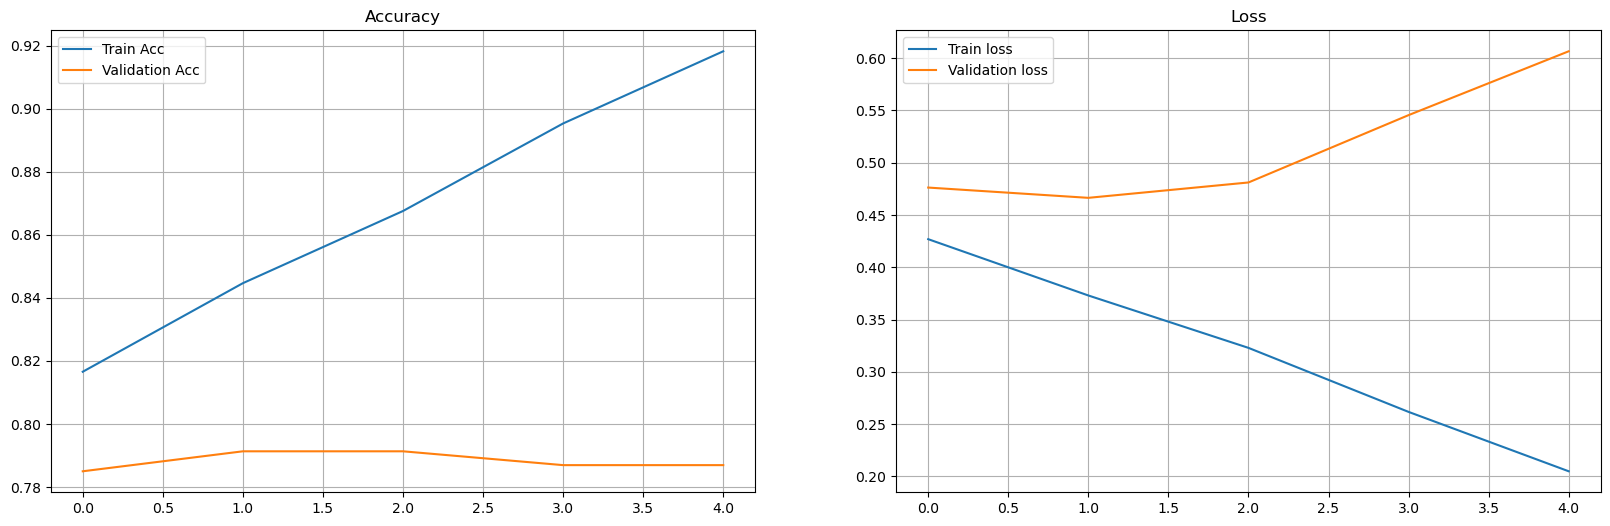

In [136]:
fig = plt.figure(figsize = (20, 6))
plt.subplot(1, 2, 1)
plt.plot(epoch_tr_acc, label='Train Acc')
plt.plot(epoch_vl_acc, label='Validation Acc')
plt.title("Accuracy")
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(epoch_tr_loss, label='Train loss')
plt.plot(epoch_vl_loss, label='Validation loss')
plt.title("Loss")
plt.legend()
plt.grid()

plt.show()

### Inference

In [137]:
def predict_text(text):
        word_seq = np.array([vocab[preprocess_string(word)] for word in text.split() 
                         if preprocess_string(word) in vocab.keys()])
        word_seq = np.expand_dims(word_seq,axis=0)
        pad =  torch.from_numpy(padding_(word_seq,500))
        inputs = pad.to(device)
        batch_size = 1
        h = model.init_hidden(batch_size)
        h = tuple([each.data for each in h])
        output, h = model(inputs, h)
        return(output.item())

In [139]:
index = 30
print(df['text'][index])
print('='*70)
print(f'Actual sentiment is  : {df["sentiment"][index]}')
print('='*70)
pro = predict_text(df['text'][index])
status = "positive" if pro > 0.5 else "negative"
pro = (1 - pro) if status == "negative" else pro
print(f'Predicted sentiment is {status} with a probability of {pro}')

سلاام 
  
   
 حلو أنك تشوف جميع مكونات الساندويتش وتختارها بنفسك . 
  
 الخبز عندهم مُغري (بالنسبة لي على الأقل ), خاصة الـبر . 
  
 الهوت دوق لذيذ .... التونة حلوه !! 
  
 أهم شي لاتنسى تاخذ الكرت اللي اذا أكملت جميع الستيكرات فيه بإمكانك تاخذ ساندويتش مجانية في المرة القادمة .
Actual sentiment is  : positive
Predicted sentiment is positive with a probability of 0.9868302941322327


In [142]:
index = 0
print(df['text'][index])
print('='*70)
print(f'Actual sentiment is  : {df["sentiment"][index]}')
print('='*70)
pro = predict_text(df['text'][index])
status = "positive" if pro > 0.5 else "negative"
pro = (1 - pro) if status == "negative" else pro
print(f'predicted sentiment is {status} with a probability of {pro}')

اولا: المنيو تغير الشورما اصبحت اعتياديه بأختفاء الصلصات والخيارات  
 ثانيا : في المره الاولي لطلبي وجدنا قطعه من قفاز الايدي في الدجاج واعتقدنا مبدأيا بأنه من جلد الدجاج  حتي تأكدنا ومنه قررنا ان لا نشتري منه لكن -للبطن احكام :-) 
 ثالثا : طلبت بالمره الاخيره الطبق المفضل لي صحن الشورما (شورما بالتر ) فجاء الطلب من غير خبز او صلصه ولا مجال للعوده للمحل والشكوي  
 قرار اخير لا اطلب من اكسبرس مجددا
Actual sentiment is  : negative
predicted sentiment is positive with a probability of 0.5117054581642151


Some improvement suggestions are as follow:

* Running a hyperparameter search to optimize your configurations.
* Using pretraned word embeddings like Glove word embeddings
* Increasing the model complexity like adding more layers/ using bidirectional LSTMs
